In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

/Users/clairesarraille/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

# from statsmodels.stats.outliers_influence import variance_inflation_factor



%matplotlib inline

In [3]:
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model

df = df.drop(['date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [5]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

# Waterfront Null Values

In [6]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [7]:
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df["waterfront"].astype(int)
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'].unique()

array([0, 1])

# Narrow to NON-Waterfront Homes

In [8]:
df =  df.loc[df['waterfront'] == 0]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21451 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              21451 non-null  int64  
 1   price           21451 non-null  float64
 2   bedrooms        21451 non-null  int64  
 3   bathrooms       21451 non-null  float64
 4   sqft_living     21451 non-null  int64  
 5   sqft_lot        21451 non-null  int64  
 6   floors          21451 non-null  float64
 7   waterfront      21451 non-null  int64  
 8   condition       21451 non-null  int64  
 9   grade           21451 non-null  int64  
 10  yr_built        21451 non-null  int64  
 11  price_millions  21451 non-null  float64
 12  acres_lot       21451 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 2.3 MB


# Distributions

In [19]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [20]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [21]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'acres_lot': '{:.2f}',  'price': '${:20,.0f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price,bedrooms,bathrooms,sqft_living,acres_lot,floors,waterfront,condition,grade,yr_built
count,"$ 21,451",21451.00,21451.00,"21,451.00",21451.00,21451.00,21451.00000,21451.00,21451.00,21451
mean,"$ 532,286",3.37,2.11,"2,072.40",0.34,1.49,0.00000,3.41,7.65,1971
std,"$ 342,808",0.93,0.76,906.04,0.95,0.54,0.00000,0.65,1.16,29
min,"$ 78,000",1.00,0.50,370.00,0.01,1.00,0.00000,1.00,3.00,1900
25%,"$ 320,000",3.00,1.75,"1,420.00",0.12,1.00,0.00000,3.00,7.00,1952
50%,"$ 450,000",3.00,2.25,"1,910.00",0.17,1.50,0.00000,3.00,7.00,1975
75%,"$ 640,000",4.00,2.50,"2,540.00",0.24,2.00,0.00000,4.00,8.00,1997
max,"$ 7,700,000",33.00,8.00,"13,540.00",37.91,3.50,0.00000,5.00,13.00,2015


## Drop Unnecessary Columns

In [22]:
# Select a subset of columns to create matrix:
df_model = df.drop(['acres_lot','id','price','waterfront'], axis=1)

In [23]:
df_model.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

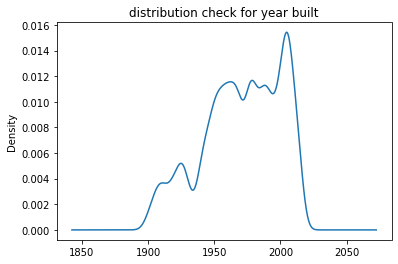

In [24]:
df_model['yr_built'].plot.kde()
plt.title("distribution check for year built") 
plt.show()

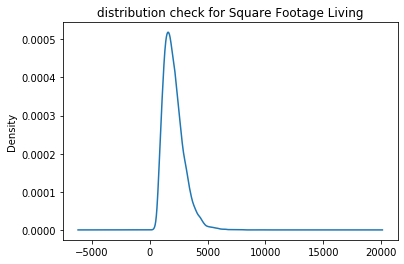

In [25]:
df_model['sqft_living'].plot.kde()
plt.title("distribution check for Square Footage Living") 
plt.show()

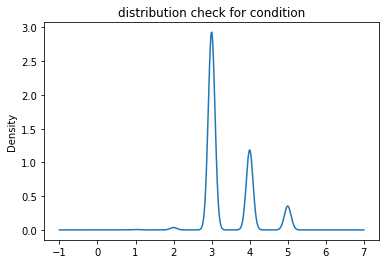

In [26]:
df_model['condition'].plot.kde()
plt.title("distribution check for condition") 
plt.show()

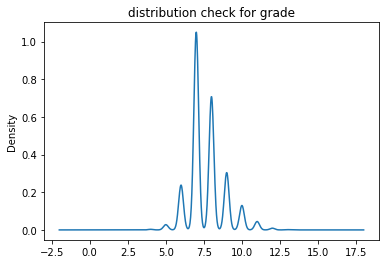

In [27]:
df_model['grade'].plot.kde()
plt.title("distribution check for grade") 
plt.show()

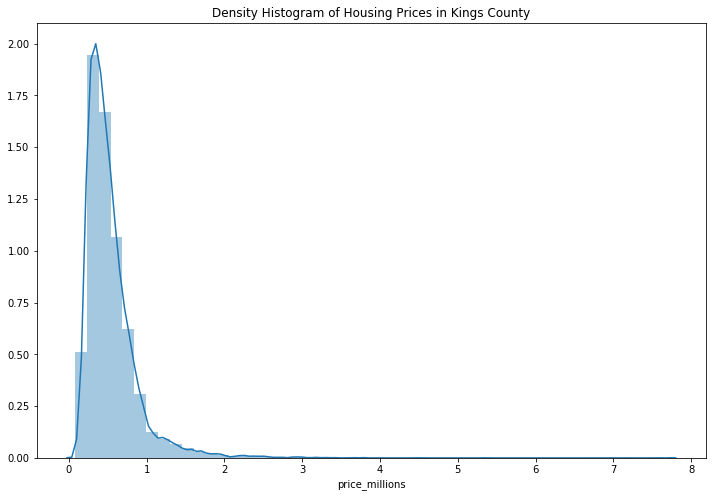

In [28]:
# From this we can see that generally, most houses are priced below one million dollars
plt.figure(figsize = (12,8))
sns.distplot(df_model.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

# Standardize Data:

In [29]:
# make copy of df_model for normalization purposes: 
df_norm = df_model.copy()

# Apply z-score normalization:
def z_score_norm(my_column):
    return (my_column - my_column.mean())/my_column.std()

for predictor in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',  'condition','grade','yr_built']:
    df_norm[predictor] = z_score_norm(df_norm[predictor])
# print normalized data: 
print(df_norm)

       bedrooms  bathrooms  sqft_living  sqft_lot    floors  condition  \
0     -0.403618  -1.454284    -0.984939 -0.226578 -0.914088  -0.629327   
1     -0.403618   0.180787     0.549206 -0.188106  0.939405  -0.629327   
2     -1.484652  -1.454284    -1.437456 -0.121458 -0.914088  -0.629327   
3      0.677417   1.161830    -0.124052 -0.242285 -0.914088   2.448577   
4     -0.403618  -0.146227    -0.433088 -0.167855 -0.914088  -0.629327   
...         ...        ...          ...       ...       ...        ...   
21592 -0.403618   0.507801    -0.598644 -0.335781  2.792898  -0.629327   
21593  0.677417   0.507801     0.262243 -0.222639  0.939405  -0.629327   
21594 -1.484652  -1.781299    -1.161531 -0.330489  0.939405  -0.629327   
21595 -0.403618   0.507801    -0.521384 -0.305405  0.939405  -0.629327   
21596 -1.484652  -1.781299    -1.161531 -0.337110  0.939405  -0.629327   

          grade  yr_built  price_millions  
0     -0.558350 -0.546565        0.221900  
1     -0.558350 -0.6827

## Linear Regression - Ordinary Least Squares

In [30]:
# Split normalized data into target variable and predictors/explanatory variables/independent variables
X = df_norm.drop(['price_millions'], axis=1) # independent variables
y = df_norm['price_millions'] # target variable

In [31]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for teh testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups
# So we have good proportions of randomly selected data and our 30-70 split has good representation 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)


In [32]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
lr = LinearRegression()

In [33]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
coef_list = list(lr.coef_)
name_list = list(X_train.columns)
pd.Series(coef_list, index=name_list)

bedrooms      -0.039895
bathrooms      0.042174
sqft_living    0.151231
sqft_lot      -0.006250
floors         0.011829
condition      0.014309
grade          0.152064
yr_built      -0.114111
dtype: float64

In [34]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [35]:
# Model Evaluation:
# In this case, our model only explains 64% of the variation in our data 
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6252639004561333


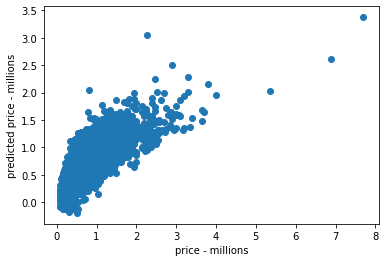

In [36]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

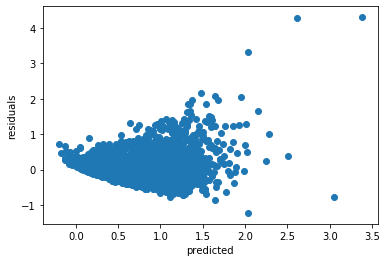

In [37]:
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation 
# Residual = Observed – Predicted
# Positive Y-values indicate the value by which the prediction was too low
# Negative Y-values indicate the value by which the prediction was too high
# Here, the model was anywhere from 5 million too low, to -2 million too high, which is quite a lot
# Additionally, the distribution of the residuals follows a clear pattern and therefore exhibits heteroscedasticity
# One of the required assumptions for linear regression is homoscedasticity (equally distributed residuals across the regression line), which we clearly do not have here


plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

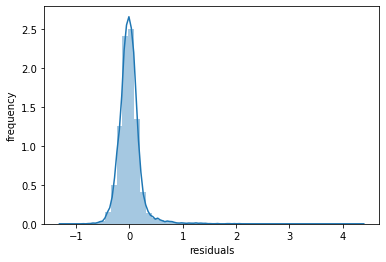

In [38]:
# See if a model of our residuals (error) follows a normal distribution:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [39]:
# Finally, we take the 30% of that data we set aside for testing, and examine the error for that:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))



The R squared value is: 0.6235258956119951
